In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split , GridSearchCV , ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.impute import KNNImputer
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [26]:
dp = pd.read_csv("/kaggle/input/titanic/train.csv") 
dp[["Embarked", "Sex"]]

,Embarked,Sex
0,S,male
1,C,female
2,S,female
3,S,female
4,S,male
...,...,...
886,S,male
887,S,female
888,S,female
889,C,male


In [27]:
dp.groupby('Embarked').size()

Embarked
C    168
Q     77
S    644
dtype: int64

In [28]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")

print(train_data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [29]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [30]:
print(train_data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [31]:
y_train = train_data["Survived"].values
train_data["Sex"] = train_data["Sex"].replace({"male":0, "female":1})
train_data["Embarked"] = train_data["Embarked"].replace({'C': 0, 'Q': 1, 'S': 2})

train_data.drop(columns=["PassengerId", "Name", "Ticket", "Cabin", "Survived"], inplace=True)

knn_imp = KNNImputer()
data = pd.DataFrame(knn_imp.fit_transform(train_data), columns=train_data.columns)

X_train = data.values

In [51]:
test = pd.read_csv("/kaggle/input/titanic/test.csv")
passenger_ID = test["PassengerId"]
test["Sex"] = test["Sex"].replace({"male": 0, "female": 1})
test["Embarked"] = test["Embarked"].replace({'C': 0, 'Q': 1, 'S': 2})
test.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], inplace=True)

knn_imp = KNNImputer()
test = pd.DataFrame(knn_imp.fit_transform(test), columns=test.columns)

X_test = test.values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

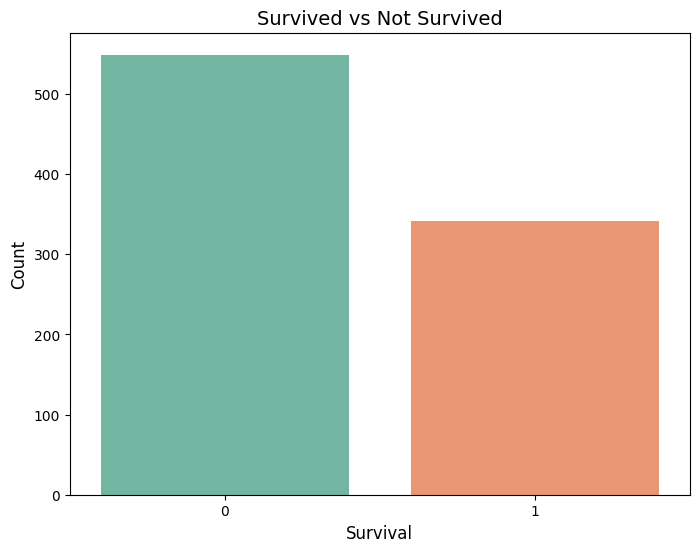

In [35]:
plt.figure(figsize=(8,6))
sns.countplot(x=y_train, data=data, palette="Set2")
plt.title("Survived vs Not Survived", fontsize=14)
plt.xlabel("Survival", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

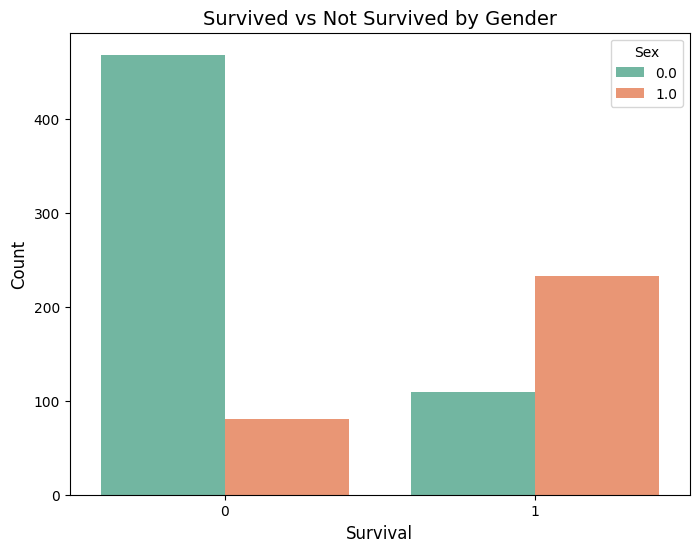

In [38]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train, hue='Sex', data=data, palette="Set2")

plt.title("Survived vs Not Survived by Gender", fontsize=14)
plt.xlabel("Survival", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.show()

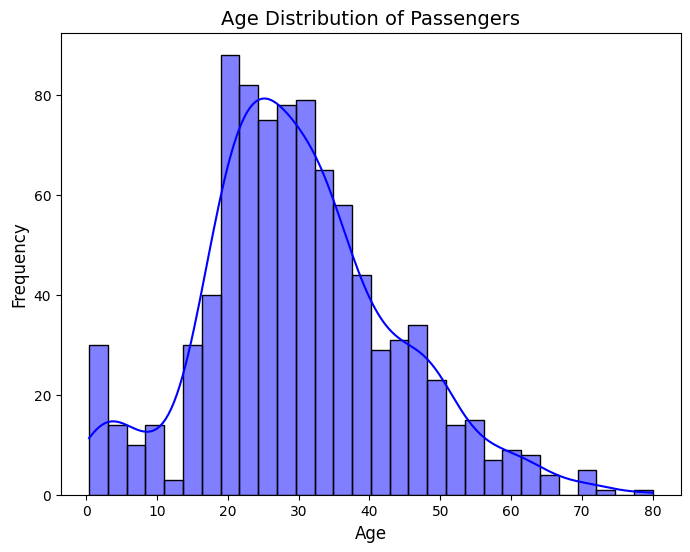

In [36]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Age'], kde=True, color='blue', bins=30)
plt.title("Age Distribution of Passengers", fontsize=14)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

# XGBoost

In [39]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

xgb_clf.fit(X_train, y_train)

y_pred_train = xgb_clf.predict(X_train)
classification_report(y_train, y_pred_train)

'              precision    recall  f1-score   support\n\n           0       0.97      0.99      0.98       549\n           1       0.98      0.95      0.96       342\n\n    accuracy                           0.97       891\n   macro avg       0.97      0.97      0.97       891\nweighted avg       0.97      0.97      0.97       891\n'

Hyperparameter Tuning 

In [40]:
cv = ShuffleSplit(5, test_size=0.20, random_state=42)

param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 200, 300]
}

xgb_grid = GridSearchCV(xgb_clf, param_grid=param_grid, scoring="accuracy", return_train_score=True, verbose=0)
xgb_grid.fit(X_train, y_train)
print(xgb_grid.best_params_)
print("Best GridSearchCV Score: ", xgb_grid.best_score_)

best_xgb = xgb_grid.best_estimator_

best_xgb.fit(X_train, y_train)

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Best GridSearchCV Score:  0.8350637122591176


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [41]:
y_pred = best_xgb.predict(X_test)

output = pd.DataFrame({'PassengerId': passenger_ID, 'Survived': y_pred})

output.to_csv('submission.csv', index=False)

<Figure size 1000x800 with 0 Axes>

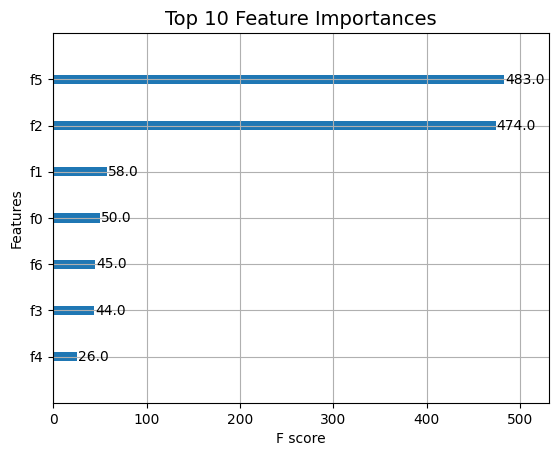

In [42]:
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_xgb, importance_type='weight', max_num_features=10)
plt.title("Top 10 Feature Importances", fontsize=14)
plt.show()

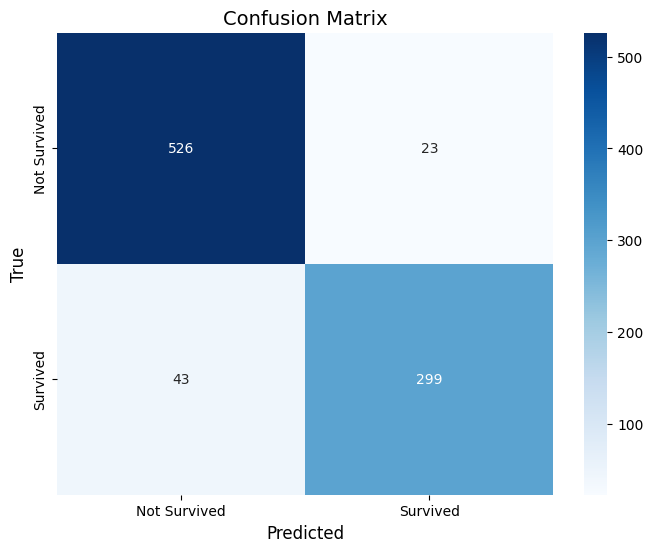

In [43]:
cm = confusion_matrix(y_train, best_xgb.predict(X_train))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Survived", "Survived"], yticklabels=["Not Survived", "Survived"])
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.show()

In [44]:
output.to_csv('submission.csv', index=False)

# Random Forest Classifier

In [53]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [54]:
output = pd.DataFrame({'PassengerId': passenger_ID, 'Survived': y_pred})

output.to_csv('submission.csv', index=False)